# Multimodal Similarity Search Service

### Dataset preparation

In [1]:
from pathlib import Path
import polars as pl

DATA_ROOT = Path("abo-images-small")

meta_path = DATA_ROOT / "images" / "metadata" / "images.csv.gz"
df = pl.read_csv(meta_path)

df.head()

image_id,height,width,path
str,i64,i64,str
"""010-mllS7JL""",106,106,"""14/14fe8812.jpg"""
"""01dkn0Gyx0L""",122,122,"""da/daab0cad.jpg"""
"""01sUPg0387L""",111,111,"""d2/d2daaae9.jpg"""
"""1168jc-5r1L""",186,186,"""3a/3a4e88e6.jpg"""
"""11RUV5Fs65L""",30,500,"""d9/d91ab9cf.jpg"""


In [2]:
MIN_SIZE = 1000

df_valid = df.filter((pl.col("width") >= MIN_SIZE) & (pl.col("height") >= MIN_SIZE))

df_valid.head()

image_id,height,width,path
str,i64,i64,str
"""21LlmxUCtTS""",1080,1920,"""46/4689906d.png"""
"""41++65Gq75L""",1000,1000,"""0c/0cd7596c.jpg"""
"""41+-6PFLrzL""",1000,1000,"""e6/e602a9af.jpg"""
"""41+3Rii3WqL""",1000,1000,"""e7/e7cfeb02.jpg"""
"""41+7D+3hkuL""",1200,1200,"""68/6839db4e.jpg"""


### Model Selection

In [3]:
from sentence_transformers import SentenceTransformer
from PIL import Image

# Load CLIP model
model = SentenceTransformer("clip-ViT-B-32")

# Encode an image:
img_path = DATA_ROOT / "images" / "small" / "46/4689906d.png"
img_emb = model.encode(Image.open(img_path))

# Encode text descriptions
text_emb = model.encode("random text")

print(f"Image embedding size: {img_emb.shape}")
print(f"Image embedding size: {text_emb.shape}")

Image embedding size: (512,)
Image embedding size: (512,)


**Questions:**

What is the vector size produced by clip-ViT-B-32?
- the embedding vector size is 512 dimensions for both text and image data

What do ViT, B and 32 mean in the model name?
- ViT - Vision Transformer
- B - model size, B means Base (moderate size)
- 32 - patch size, the image is split into 32×32 pixel patches before feeding them into the transformer


### Database setup

- run `docker compose up -d` to make sure the database from the lab is up and running
- connected via psql to check if the `similarity_search_service_db` database is still there

In [4]:
from sqlalchemy.engine import URL

db_url = URL.create(
    drivername="postgresql+psycopg",
    username="postgres",
    password="password",
    host="localhost",
    port=5555,
    database="similarity_search_service_db",
)

In [5]:
from pgvector.sqlalchemy import Vector
from sqlalchemy import String
from sqlalchemy.orm import DeclarativeBase, Mapped, mapped_column


class Base(DeclarativeBase):
    __abstract__ = True


class Img(Base):
    __tablename__ = "images"
    __table_args__ = {"extend_existing": True}

    VECTOR_LENGTH: int = 512  # CLIP ViT-B-32 embeddings are 512-dimensional

    id: Mapped[int] = mapped_column(primary_key=True)
    image_path: Mapped[str] = mapped_column(String, unique=True, nullable=False)
    embedding: Mapped[list[float]] = mapped_column(Vector(VECTOR_LENGTH))

In [15]:
from sqlalchemy import create_engine

engine = create_engine(db_url)

Base.metadata.create_all(engine)

### Image vectorization 

In [7]:
import joblib
import torch
from PIL import Image
from sentence_transformers import SentenceTransformer
from tqdm.notebook import tqdm

from pathlib import Path
from itertools import islice
from typing import Iterable, List
from sqlalchemy.orm import Session

In [8]:
def batched(iterable: Iterable, n: int):
    """
    Yield successive batches (lists) of size n from an iterable.
    Example: batched(range(10), 3) -> [0,1,2], [3,4,5], [6,7,8], [9]
    """
    it = iter(iterable)
    while batch := list(islice(it, n)):
        yield batch

In [9]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cpu


In [16]:
model = SentenceTransformer("clip-ViT-B-32", device=device)

MAX_IMAGES = 10000

BATCH_SIZE = joblib.cpu_count(only_physical_cores=True)
BATCH_SIZE

8

In [17]:
def insert_images(engine, images: List[Img]) -> None:
    """
    Insert a batch of Img objects into the database in a single transaction.
    """
    if not images:
        return

    with Session(engine) as session:
        session.add_all(images)
        session.commit()


def vectorize_images(engine, model: SentenceTransformer, image_paths):
    """
    For each image path:
    - open the image,
    - compute CLIP embedding,
    - create Img(row) objects,
    - insert them into Postgres in batches.

    Only the first MAX_IMAGES paths are processed.
    """
    paths = image_paths[:MAX_IMAGES]

    with tqdm(total=len(paths)) as pbar:
        for image_paths_batch in batched(paths, BATCH_SIZE):
            pil_images = []
            for path in image_paths_batch:
                img = Image.open(path).convert("RGB")
                pil_images.append(img)

            # compute embeddings for the batch
            embeddings = model.encode(
                pil_images,
                convert_to_numpy=True,
                normalize_embeddings=True,  # makes cosine similarity more meaningful
            )  # shape: (batch_size, 512)

            # create Img objects for each image in the batch
            imgs_to_insert: List[Img] = []
            for path, emb in zip(image_paths_batch, embeddings):
                img_row = Img(
                    image_path=str(path),
                    embedding=emb.astype(
                        "float32"
                    ).tolist(),  # list[float] for pgvector
                )
                imgs_to_insert.append(img_row)

            # insert batch into db
            insert_images(engine, imgs_to_insert)

            pbar.update(len(imgs_to_insert))

In [18]:
# getting paths relative to current dir
DATA_ROOT = Path("abo-images-small")
IMAGE_DIR = DATA_ROOT / "images" / "small"

relative_paths = df_valid["path"].to_list()

image_paths = [str(IMAGE_DIR / p) for p in relative_paths]

len(image_paths), image_paths[:3]

(342878,
 ['abo-images-small/images/small/46/4689906d.png',
  'abo-images-small/images/small/0c/0cd7596c.jpg',
  'abo-images-small/images/small/e6/e602a9af.jpg'])

In [19]:
vectorize_images(engine, model, image_paths)

  0%|          | 0/10000 [00:00<?, ?it/s]

### Search and results display

In [20]:
import matplotlib.pyplot as plt
from sqlalchemy import select


class ImageSearch:
    def __init__(self, engine, model):
        self.engine = engine
        self.model = model

    def __call__(self, image_description: str, k: int, max_images: int | None = None):
        images = self.find_similar_images(image_description, k, max_images)
        self.display_images(images)

    def find_similar_images(
        self, image_description: str, k: int, max_images: int | None = None
    ):
        # encode the text description with CLIP
        image_embedding = self.model.encode(
            image_description, convert_to_numpy=True, normalize_embeddings=True
        )

        # remember about session and commit
        # smallest cosine distance = most similar
        with Session(self.engine) as session:
            query = select(Img)
            if max_images is not None:
                query = query.where(Img.id <= max_images)

            query = query.order_by(
                Img.embedding.cosine_distance(image_embedding)
            ).limit(k)
            result = session.execute(query)
            imgs = result.scalars().all()
        return [img.image_path for img in imgs]

    def display_images(self, images):
        k = len(images)
        fig, axes = plt.subplots(1, k, figsize=(5 * k, 5))

        if k == 1:
            axes = [axes]

        for i, img_path in enumerate(images):
            img = Image.open(img_path)
            axes[i].imshow(img)
            axes[i].axis("off")
            axes[i].set_title(f"Image {i + 1}")

        plt.show()

**Comment:**

Instead of recomputing image embeddings multiple times for different MAX_IMAGES values, I embedded a larger dataset (e.g., 10 000 images) once and stored all embeddings in the database.
To simulate smaller dataset sizes (e.g., 500 or 2 000 images), I restrict the search query dynamically by filtering rows with id <= max_images.

This works because the table’s primary key (id) is assigned sequentially as images are inserted, so id <= N corresponds to the first N embedded images.
This avoids recomputation but still allows comparing how search quality changes with different dataset sizes.

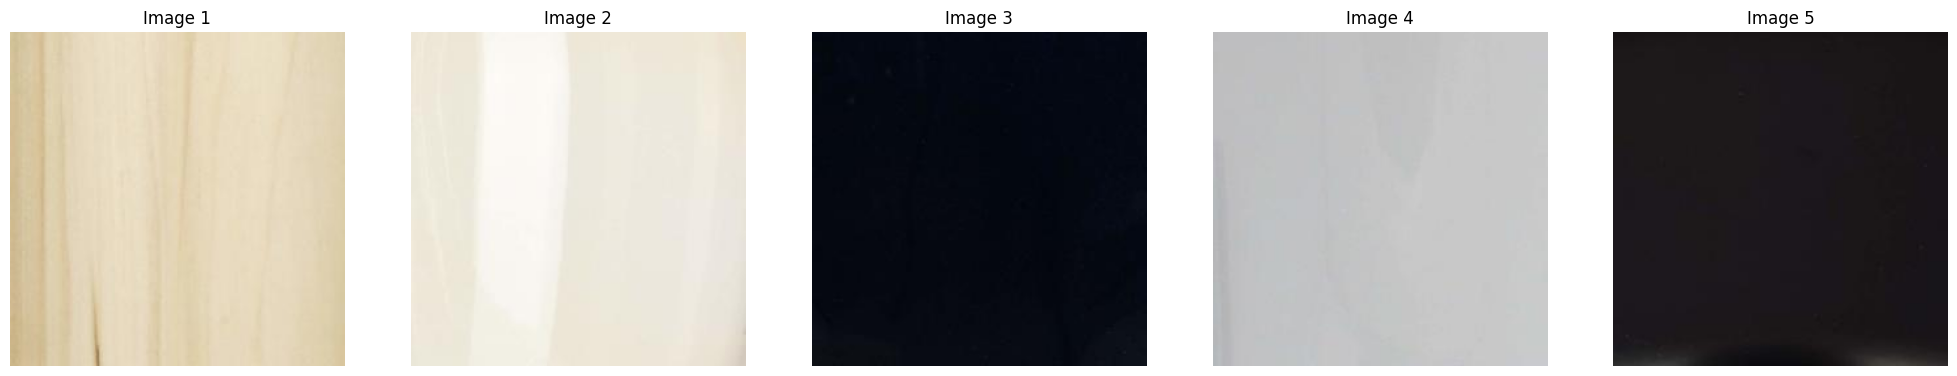

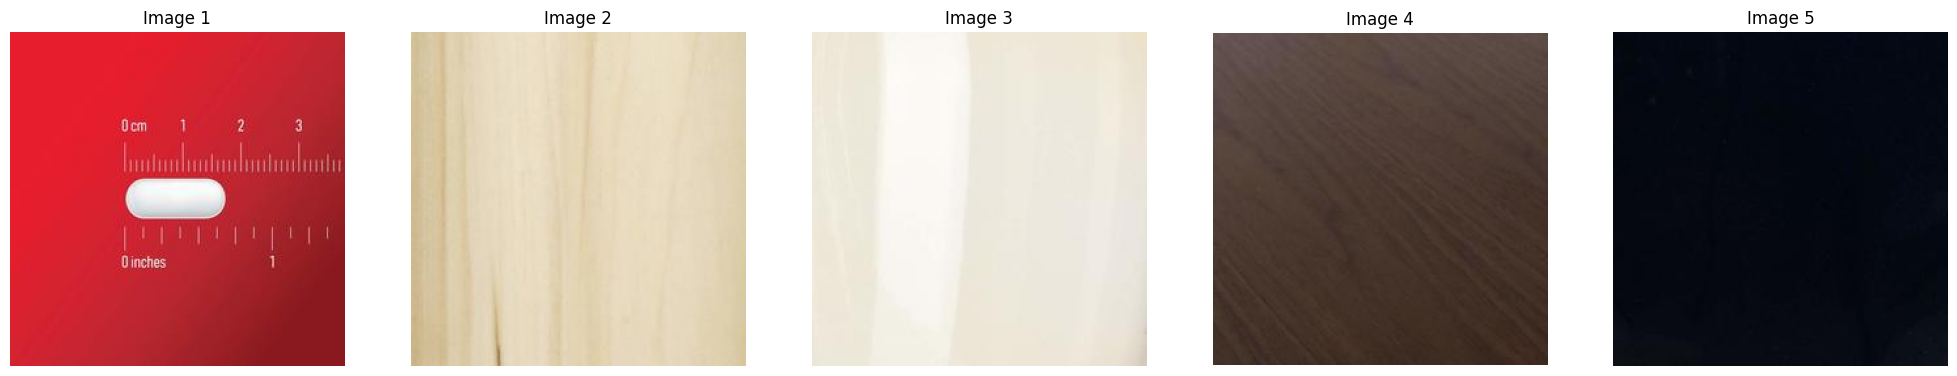

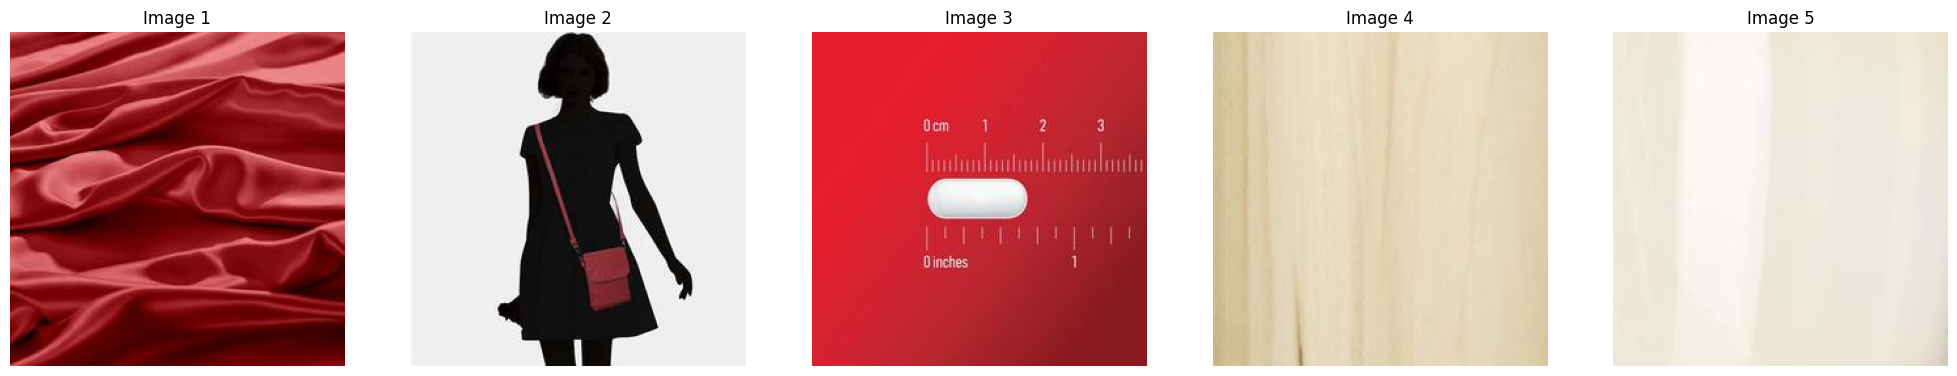

In [21]:
search = ImageSearch(engine, model)

search("red dress", k=5, max_images=2000)  # like MAX_IMAGES=2000
search("red dress", k=5, max_images=6000)  # like MAX_IMAGES=6000
search("red dress", k=5, max_images=10000)  # full dataset

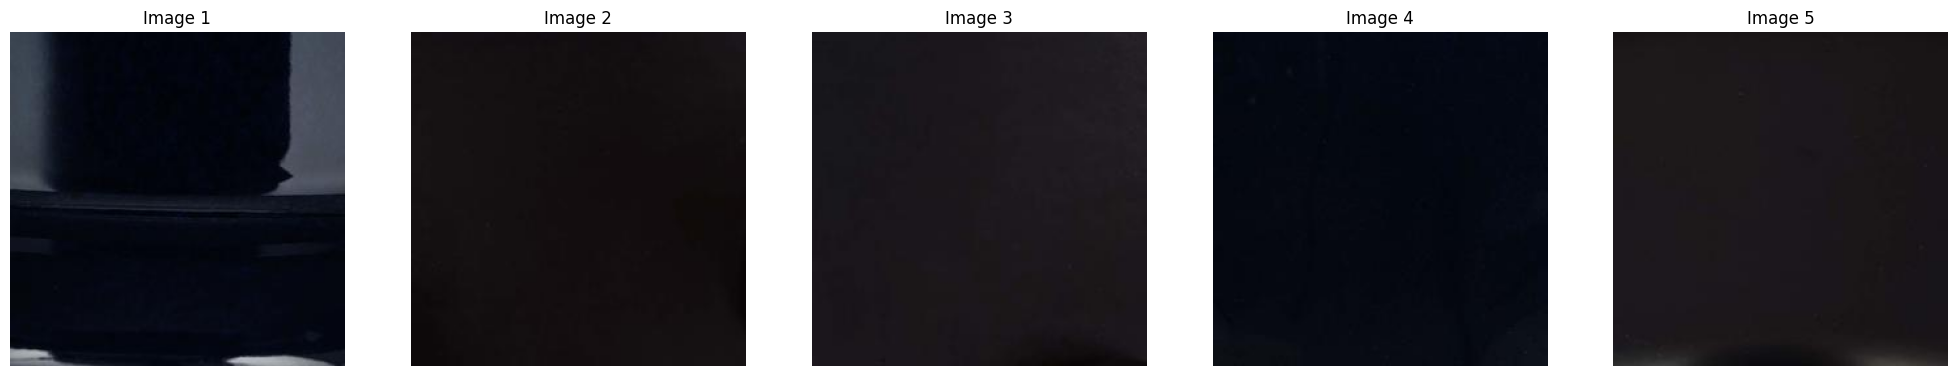

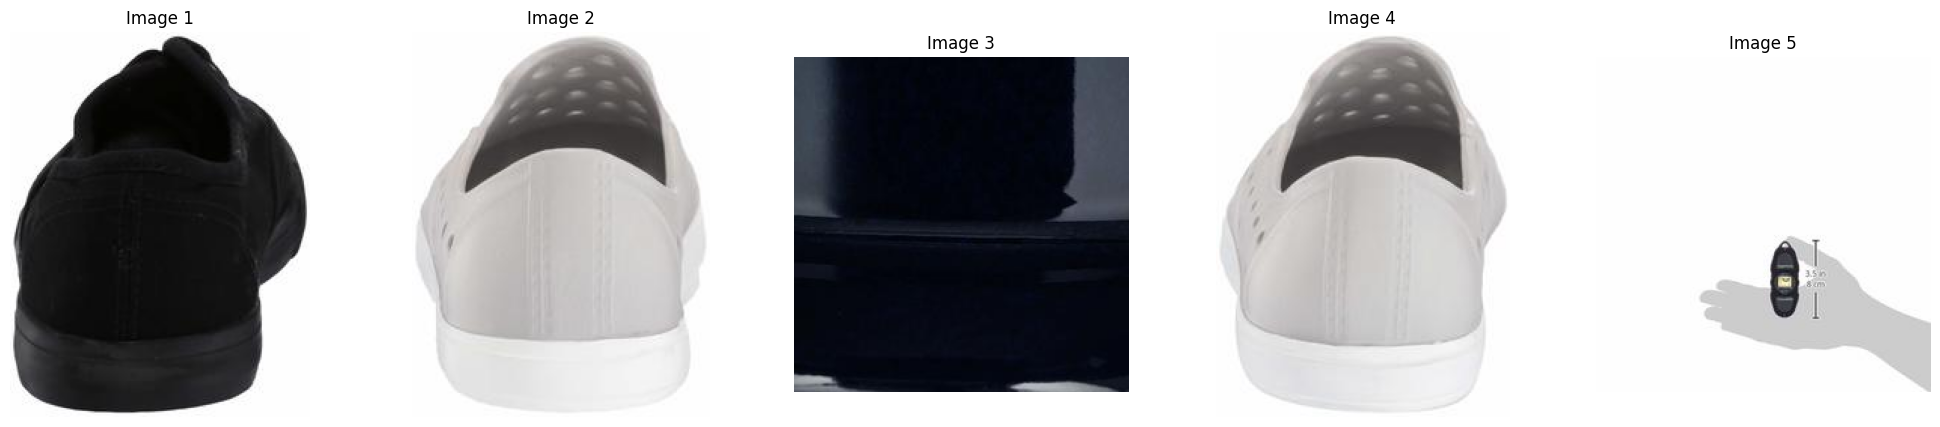

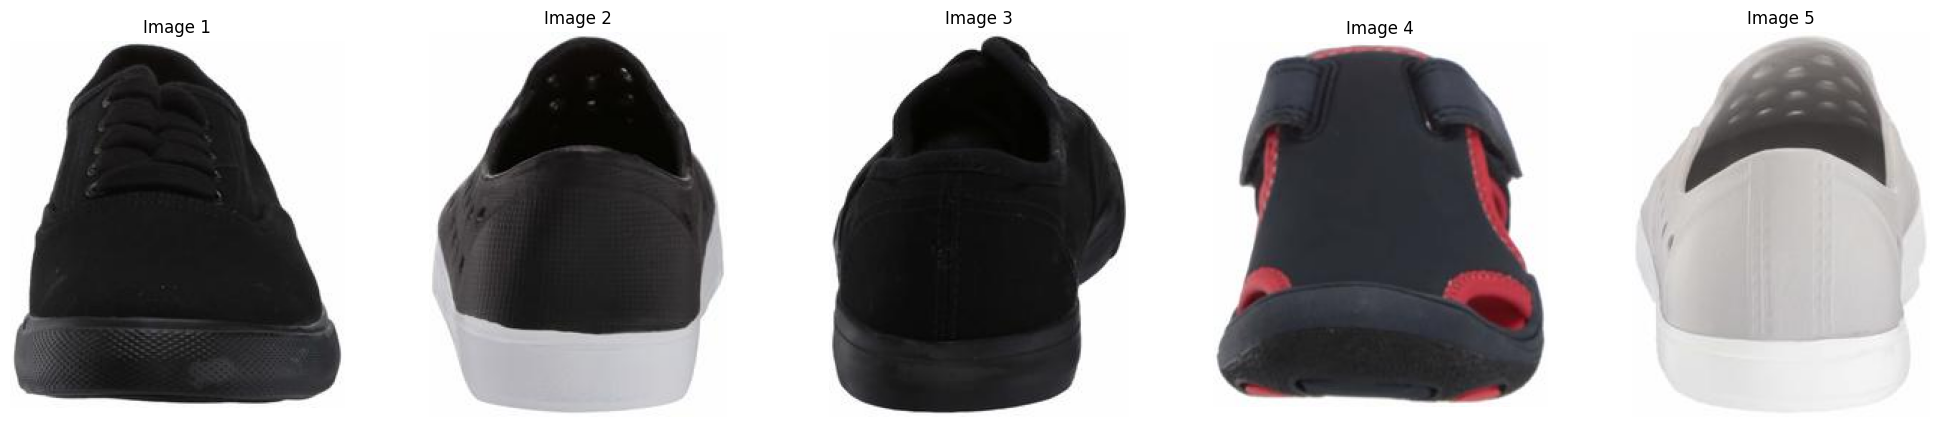

In [24]:
search("black running shoes", k=5, max_images=2000)  # like MAX_IMAGES=2000
search("black running shoes", k=5, max_images=6000)  # like MAX_IMAGES=6000
search("black running shoes", k=5, max_images=10000)  # full dataset

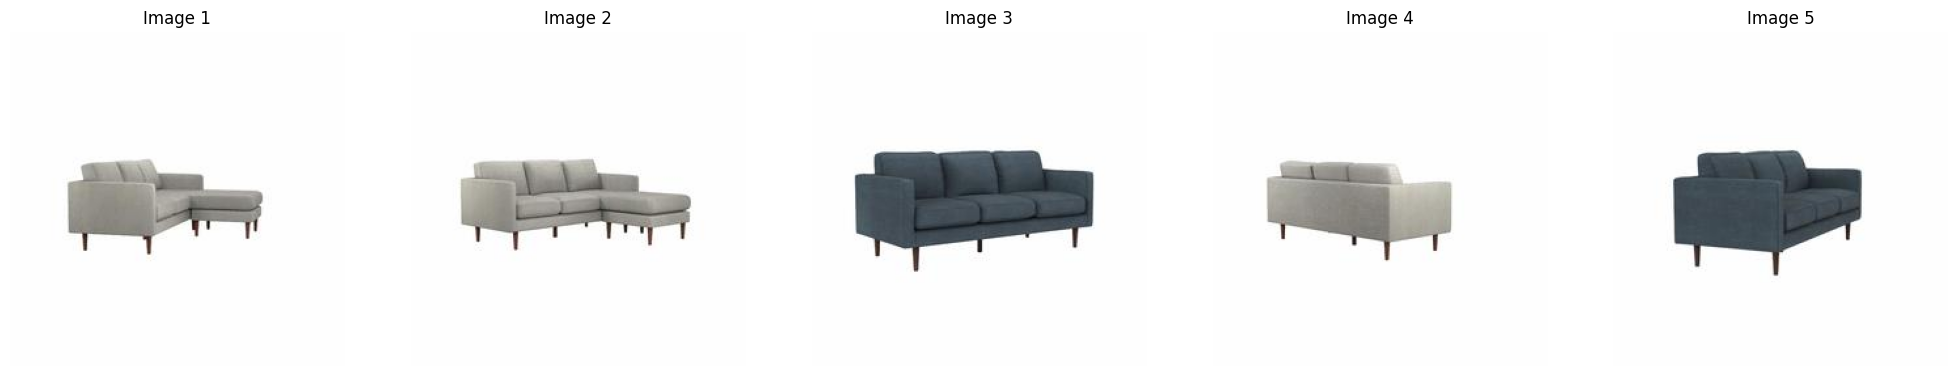

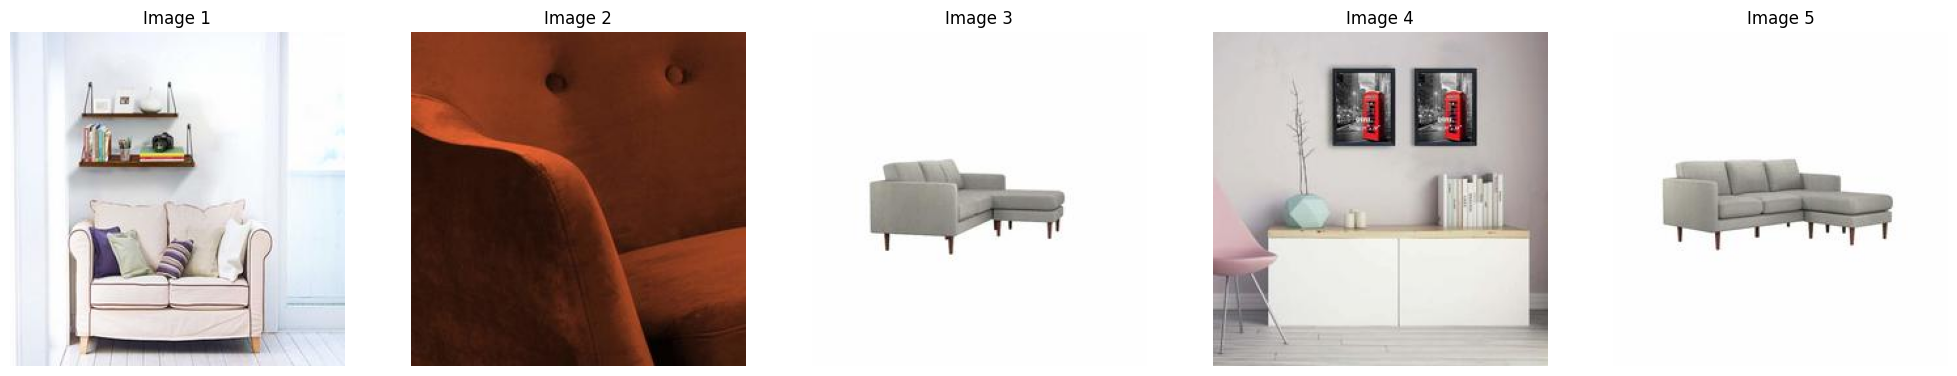

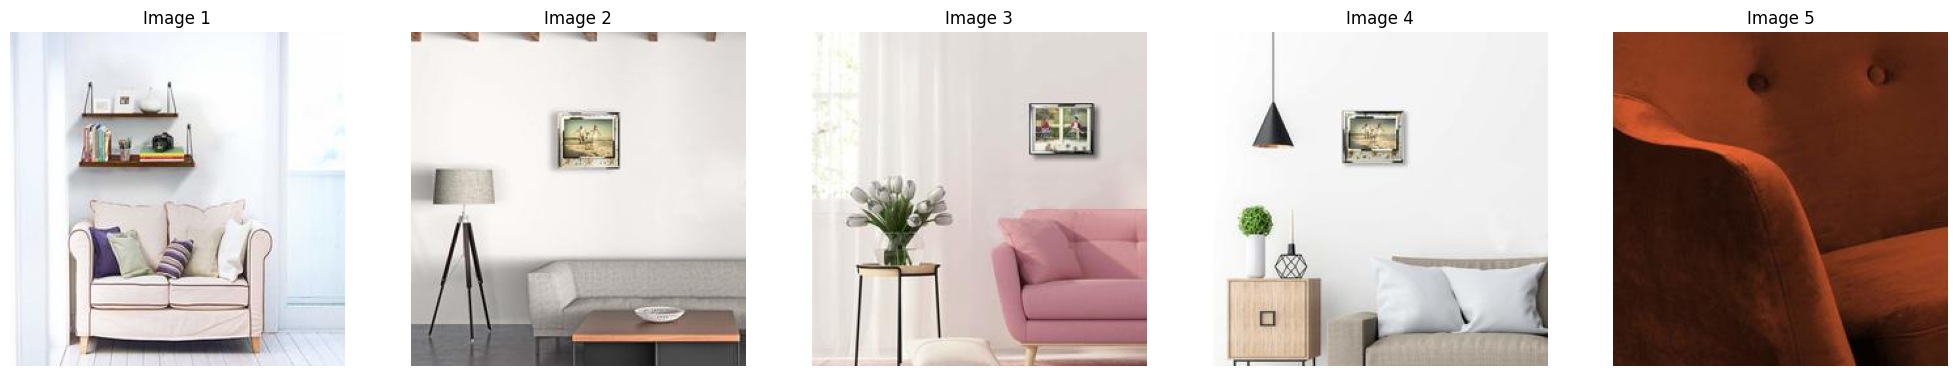

In [25]:
search("cozy living room", k=5, max_images=2000)  # like MAX_IMAGES=2000
search("cozy living room", k=5, max_images=6000)  # like MAX_IMAGES=6000
search("cozy living room", k=5, max_images=10000)  # full dataset

**Comment:**
- the results are somewhat relevant (depends on the text - for the living room it was the best)
- the relevance depends on the dataset size - the bigger the better
- the relevance also depends on the "closeness" of the nearest neighbour - the nearest is more accurate (first in the sequence of displayed images)